# Rabi Oscillation Experiment with Deltaflow

In this notebook we will walk through a "Hello World" Deltaflow program,
which implements a Rabi cycle on a single qubit.
This example will also provide a demonstration of programming nodes to
run on both CPUs and FPGAs across different levels of the stack.

Rabi oscillations are the basic process to manipulate qubits;
in the circuit model of quantum computation it corresponds to performing
a rotation on a qubit around some axis of the Bloch sphere.
A Rabi cycle can be generated by performing a series of rotations between
0 and $2 \pi$ around this axis, and measuring the probabilty of
a certain outcome (0 or 1) for each angle.

In this example we will perform rotations around the x-axis of the
Bloch sphere, starting from the 0-state of the compuational basis
(positive z-axis).

This notebook assumes some proficiency in the Deltaflow language,
though concepts will be explained where required.

All code presented here is contained within modules in the current
directory, we import and present those modules in this notebook
for transparency and extra explanation. 

## Structure of `DeltaGraph`

The Rabi cycle may be implemented in Deltaflow by considering a breakdown of
the various elements in the experiment:

- **Experiment Orchestrator**:

    - the top-level process which waits for experiments completion. Exists at the CPU layer;

- **HAL Interface**:

    - the interface to the quantum system;

    - accepts HAL commands (i.e. quantum gates/circuits) to manipulate qubits
    (e.g. `STATE_PREPARATION`, `RX`, `STATE_MEASURE`);

    - returns measurements of qubits (0 or 1);
    
- **Result Aggregator**:

    - informs which rotation angle to perform measurements for,
    which then determines the circuits that are sent to the _HAL Interface_;

    - aggregates the measurement results from the _HAL Interface_
    to compute the probability of measurement for a given rotation angle;

    - iterates over the above for all rotation angles required;

    - also informs the _Experiment Orchestrator_ when all results
    are aggregated for all rotation angles;

    - deals with the inputs/outputs concurrently at the FPGA layer;

- **Command Sender**:
    - a process that sends a series of commands to the HAL in order to
    carry out a quantum circuit, the commands will be parameterised by
    a rotation angle, informed by the _Result Aggregator_;

    - exists at the FPGA layer;

    - NOTE: it is possible to combine this element with the _Result Aggregator_,
    but we separate it out for clarity;

- **Result Store**:

    - somewhere to collect and store results from the _Result Aggregator_;

    - Exists at the CPU layer, with data stored via asynchronous output
    from the FPGA to CPU.

Each of these may be implemented as nodes in `DeltaGraph`;
below is a schematic of what is will look like:

<div>
<img src="rabi-schematic.png" width="800"/>
</div>

Let's implement each of them in order of complexity.

## Constructing Nodes for the DeltaGraph

### Result Store

For this node we do not need to do any coding and can make use of
a standard primitive available in the Deltaflow library.
An object of this class can be used in `DeltaGraph` to store data.

### HAL Interface

For this example we will use a pure-Python HAL simulation of a real-world qubit control system.
In reality this node will be defined quite differently, most likely by a _template node_,
where access to the qubit system will be determined later by a specific runtime,
but still conform to some pre-determined interface specified by the template node.
For now though, we will keep things simple in order to demonstrate building `DeltaGraph`.

Again we do not have to do any coding here, and can make use of pre-existing code
structures in the Deltaflow libraries.

In `deltalanguage/lib` we have a pre-defined class representing a HAL node,
namely the `HardwareAbstractionLayerNode` class, which specifies the expected
communication with a HAL.
The principal method of this class is a `@DeltaMethodBlock` called `accept_command`,
which accepts input in the form of 32-bit HAL commands (of type `DInt(DSize(32))`),
and returns a 0 or a 1 when a `STATE_MEASURE` command is supplied.

To instantiate this class we require a `quantum_simulator` input to the constructor
that implements the `IQuantumSimulator` interface found in
`deltalanguage/lib`.
The library also provides a concrete implentation of this interface using a _ProjectQ_ backend,
which is also found in the same directory.

A HAL node, using a _ProjectQ_ backended `quantum_simulator` can be instantiated like so:

```
q_sim = HardwareAbstractionLayerNode(
    ProjectqQuantumSimulator(register_size=1)
)
```

For this experiment we only require a single qubit, hence `register_size=1`,
but in general larger register sizes may be specified when using this class.

### Command Sender

We now enter the world of Migen. For a more basic introduction to Migen nodes in
Deltaflow its worth looking at the corresponting section of the tutorial.

We will use Migen nodes to define program logic close to the HAL (at the FPGA layer),
i.e. for processes that send HAL commands and receive measurement results.
In general we will want to use FPGA logic for low-latency operations;
in this example we will just use it for sending HAL instructions and aggregating some
simple statistics from HAL measurements.

This node has a single input signal and a single output signal:

- Input:
    - `angle`: a 10-bit representation of a rotation angle, to define the _argument_ for the rotation HAL command;
    
- Output:
    - `hal_command`: a 32-bit HAL command comprising of an _opcode_ (31-26), _argument_ (25-16) and _qubit index_ (15-0).

We desire the following behaviour: as long as there is a valid signal on the _angle_
input for a given clock cycle, we should trigger an ordered series of output signals,
which encode HAL commands defining a quantum circuit for a single RX qubit rotation.

So for times:

- `t = 0`, if the `angle` signal is valid with data `x`, then at
- `t = 1`, `STATE_PREAPARATION` HAL instruction available on `hal_command` output signal
- `t = 2`, `RX` HAL instruction with `x` argument available on `hal_command` output signal
- `t = 3`, `STATE_MEASURE` HAL instruction available on `hal_command` output signal

If at time `t = 4` the `angle` signal is still valid, then we should trigger the
process again using whatever data value `x` is specified, otherwise it should wait until
the `angle` signal is valid. This can be done using a Migen _state machine_.

Below is a Migen node defined for the _Command Sender_ which implements this behaviour:

In [1]:
%pycat commander.py

from migen import FSM, If, NextState, NextValue, Signal

from deltalanguage.data_types import DUInt, DOptional, DSize
from deltalanguage.lib import command_creator
from deltalanguage.wiring import MigenNodeTemplate

from examples.rabi_demo.aggregator import ANGLE_MEMORY_WIDTH


class Commander(MigenNodeTemplate):
    """Migen node that contains a state machine to trigger HAL commands
    that execute a Rabi circuit by state preparation, qubit rotation (RX),
    and state measurement.

    Input signals:
    - angle: the representation of the rotation angle with a variable size

    Output signals:
    - hal_command: the 32-bit HAL command
    """

    def migen_body(self, template):
        # creation of input/output ports
        angle = template.add_pa_in_port(
            'angle',
            DOptional(DUInt(DSize(ANGLE_MEMORY_WIDTH)))
        )

        hal_command = template.add_pa_out_port('hal_command', DUInt(DSize(32)))

        # set up  internal signals
        _rotation_comm

This migen node essentially cycles between three states:

- `STATE_PREPARATION`
- `ROTATION`
- `STATE_MEASURE`

triggered by the data made available on the input signal (the `angle`),
which makes output data available on the `hal_command` signal depending on which state we are in.

### Result Aggregator

This final node is the most complicated, and also written in Migen to
be processed at the FPGA layer.
Not only is it in charge of controlling the input `angle` signal to the **Command Sender**,
it also processes results from the **HAL Interface**, makes these results available to the
**Result Store**, and informs the **Experiment Orchestrator** that the experiment has been completed.

This node has 1 input signals and 3 output signals:

- Inputs:
    - `hal_result`: a 32-bit signal comprising of the result from the **HAL Interface**;

- Outputs:

    - `agg_result`: a signal that stores aggregation of results from the **HAL Interface**,
    and is made available to the **Result Store** when an aggregation is completed;

    - `completed`: a 1-bit signal to flag when the whole process is finished, sent to the
    **Experiment Orchestrator** once all aggregations for all angles has completed;

    - `next_angle`: a 10-bit representation of a rotation angle (between 0 and 2$\pi$),
    sent to the **Command Sender** to build the rotation circuit.

Aggregation and storage of results are carried out in a concurrent manner along with
signalling the rotation angle.

We desire the following behaviour: when there is a valid high signal on the `start` input,
kick-off an aggregation process.

The aggregation process should do the following things:

- cycle through a set of `next_angle` values, a certain amount of angles stored in memory
defined by the constant `RESOLUTION`;

- for each value, make available on the `next_angle` output signal for as many clock cycles
as required such that a certain number of values of `hal_result` can be aggregated (defined
by the constant `REPETITIONS`);

- once the aggregation limit `REPETITIONS` has been reached for a particular value of
`next_angle`, make the aggregation result available on the `agg_result` output signal,
while also cycling to the next value of `next_angle`;

- repeat the above until all values of `next_angle` have been cycled through, at which
point trigger a valid high signal on the `completed` output signal.

We can do all this with a Migen state machine, in a similar fashion to the **Command Sender_.

In [2]:
%pycat aggregator.py

from migen import Signal, FSM, If, Memory, NextValue, NextState

from deltalanguage.data_types import DBool, DInt, DUInt, DOptional, DSize
from deltalanguage.lib.hal import Masks
from deltalanguage.wiring import MigenNodeTemplate

from examples.rabi_demo.helper_functions import generate_angles


ANGLE_MEMORY_WIDTH = 10  # argument length of HAL command
RESOLUTION = 4  # the total number of points is 2**RESOLUTION
REPETITIONS = 50  # number of shots for each point


class Aggregator(MigenNodeTemplate):
    """Migen node that contains a state machine to trigger signals that output

    Input signals:
    - hal_result: signal representing result from the HAL

    Output signals:
    - agg_result: signal that stores aggregation of HAL results
    - completed: signal to flag when the whole process is finished
    - next_angle: the representation of the rotation angle with a variable size
    """

    def migen_body(self, template):
        # creation of input/output ports
        hal_result

This migen node essentially cycles between three states:

- `IDLE`
- `RESULT_AGGREGATION`
- `COMPLETED`.

The `IDLE` state waits for a trigger to start on the `start` signal, then moves
straight to the `RESULT_AGGREGATION` state, which does most of the heavy lifting;
it cycles through all values of `next_angle`, aggregates data from the `hal_result`
signal, and makes the aggregations results available on the `agg_result` output signal.
When all angles are cycled through, it triggers a high signal on the `completed`
output and moves to the `COMPLETED` state, which turns off all signals.


The constants `REPETITION` and `RESOLUTION` at the top of this definition can be used
to define the outputs of the experiment:

- `REPETITION`: change this to alter the number of repetitions of each `next_angle` to
compute measurements for, in order to aggregate statistics for the measurement probability.
The higher this value, the better the results, but the longer the experiment takes;
- `RESOLUTION`: change this to determine the number of angles to compute for - the amount
will be equal to `2^RESOLUTION`, distributed between 0 and 2π. The value may not exceed the
value of `ANGLE_MEMORY_WIDTH`.

## Building and simulating the graph

Now we have constructed all our nodes for the Rabi cycle experiment,
we can wire them up together in `DeltaGraph`.

We define it in a separate file as well for convenience of using with other simulators.
Here you can also see the definitions of 2 nodes that start and stop the experiment.

In [3]:
from examples.rabi_demo.exp_graph import get_graph

%pycat exp_graph.py

from deltalanguage.data_types import DBool, DInt, DUInt, DSize, NoMessage
from deltalanguage.lib import StateSaver, IntListSender
from deltalanguage.runtime import DeltaRuntimeExit
from deltalanguage.wiring import (DeltaBlock,
                                  DeltaGraph,
                                  placeholder_node_factory,
                                  template_node_factory)

from examples.rabi_demo.aggregator import Aggregator, REPETITIONS, RESOLUTION
from examples.rabi_demo.commander import Commander
from examples.rabi_demo.helper_functions import generate_angles


@DeltaBlock()
def experiment_stopper(completed: DInt(DSize(8))) -> NoMessage:
    if completed:
        if completed == 1:
            raise DeltaRuntimeExit
        else:
            print (f"The experiment returned error code: {completed}")
            raise RuntimeError("Experiment returned an error", completed)


def get_graph():
    """Return the experiments graph `DeltaGraph` and data store instances.

  

In [4]:
from deltalanguage.lib import (HardwareAbstractionLayerNode,
                               ProjectqQuantumSimulator)


graph, store = get_graph()

# set up HAL handler (quantum simulator)
q_sim = HardwareAbstractionLayerNode(
    ProjectqQuantumSimulator(register_size=1)
)
template_node = graph.find_node_by_name('template_QSim')
template_node.specify_by_func(q_sim.accept_command)

In this `DeltaGraph` we have hooked up all the necessary inputs and outputs between the nodes we have defined above.
We have also used placeholders to tie up loops, i.e. `ph_hal_result` and `ph_experiment_completed`.
We can see how the various nodes connect by printing out `DeltaGraph`.


In [5]:
print(graph)

DeltaGraph[main] {
    result_aggregator_0:
        in : (hal_result, DUInt32, 0, True)
        out: (command_sender_1.angle, DUInt10)
        out: (pass_int_3.val, DInt32)
        out: (experiment_stopper_4.completed, DInt8)
    command_sender_1:
        in : (angle, DUInt10, 0, True)
        out: (template_QSim_2.command, DUInt32)
    template_QSim_2:
        in : (command, DUInt32, 0, False)
        out: (result_aggregator_0.hal_result, DUInt32)
    pass_int_3:
        in : (val, DInt32, 0, False)
    experiment_stopper_4:
        in : (completed, DInt8, 0, False)
}



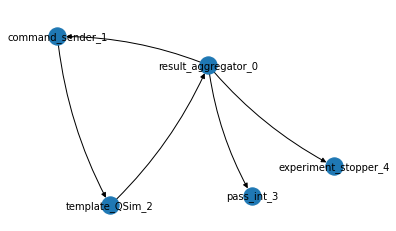

In [6]:
graph.draw(seed=5, iterations=10)

We can now run this graph and extract from the provided storage object for plotting.
Depending on the values of constants `REPETITION` and `RESOLUTION`, this may take some time...

In [6]:
from deltalanguage.runtime import DeltaPySimulator

from examples.rabi_demo.exp_graph import REPETITIONS, RESOLUTION


# run the experiment
rt = DeltaPySimulator(graph)
rt.run()

# basic checks of the results
assert len(store.saved) == 2**RESOLUTION
assert all(map(lambda x: x <= REPETITIONS, store.saved))

Let's plot the results as a function of the rotation angle:

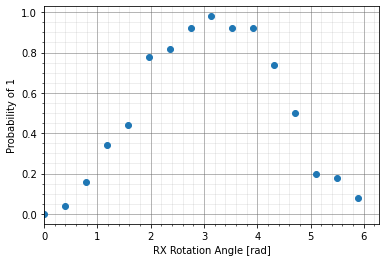

In [7]:
from matplotlib import pyplot as plt
import numpy as np

from examples.rabi_demo.helper_functions import generate_angles

# generate plot points from results
x = [i * (2 * np.pi / 1024) for i in generate_angles(RESOLUTION)]
y = [i / REPETITIONS for i in store.saved]

plt.plot(x, y, "o")
plt.xlabel("RX Rotation Angle [rad]")
plt.ylabel("Probability of 1")
plt.xlim(0, 2*np.pi)
plt.minorticks_on()
plt.grid(b=True, which="major", color="#666666", linestyle="-", alpha=0.6)
plt.grid(b=True, which="minor", color="#999999", linestyle="-", alpha=0.2)

plt.show()

You should see a plot where the probability of measuring a 1 goes from 0 to 1
back to 0 as you move from 0 to $2 \pi$ for the rotation angle!

You can change what this plot looks like by altering the constants `REPETITION`
and `RESOLUTION` described above and rerunning the subsequent cells.

## Conclusions

In this simple demonstration we have showed the following interesting points:

- the logic of the experiment has been spread accross several peices of
hardare, including CPU and FPGA;

- the _fast_ FPGA logic has been responsible for quick interaction with the
quantum hardware without _slower_ interaction with CPU, except the beginning and
end of the experiment;

- the interaction with the quantum hardware has been facilitated via a
HAL layer that was responsible for encoding and decoding operational commands.